In [46]:
# img1 o model o query
# img2 o scena

In [47]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [48]:
MEDIAN_K_SIZE = 3
MEDIAN2_K_SIZE = 3

FLANN_INDEX_KDTREE = 1
MIN_MATCH_COUNT = 0 #10


In [49]:
def png_to_numpy(path, list):
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        list.append(image)


In [50]:
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

models_multiple_instances = []
scenes_multiple_instances = []

png_to_numpy(MODELS_MULTIPLE_INSTANCES_PATH, models_multiple_instances)
png_to_numpy(SCENES_MULTIPLE_INSTANCES_PATH, scenes_multiple_instances)

print(f"{len(models_multiple_instances)} models and {len(scenes_multiple_instances)} scenes for multiple instances detection task")

multi_instance_real_matchings = {0: [(6, 2), (7, 2)],
                                 1: [(2, 2), (8, 2), (9, 3)], 
                                 2: [(10, 2), (11, 2), (3, 2)], 
                                 3: [(0, 2)], 
                                 4: [(1, 2)], 
                                 5: [(2, 2), (8, 1)],
                                 6: [(3, 2), (4, 2), (5, 2)]}

12 models and 7 scenes for multiple instances detection task


In [51]:
def denoise_image(image):
    denoised_image = cv2.medianBlur(image, MEDIAN_K_SIZE)
    denoised_image = cv2.medianBlur(denoised_image, MEDIAN2_K_SIZE)
    denoised_image = cv2.bilateralFilter(denoised_image, d=19, sigmaColor=50, sigmaSpace=250)
    denoised_image = cv2.bilateralFilter(denoised_image, d=19, sigmaColor=20, sigmaSpace=120)
    return denoised_image

def get_good_matches(des_model, des_scene, ratio_thresh = 0.7):
    #-- Step 1: Matching descriptor vectors with a FLANN based matcher
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(des_model, des_scene, k=2)
    
    #-- Step2: Filter matches using the Lowe's ratio test
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    return good_matches

### Zero Mean Normalized Cross-Correlation

In [52]:
def getAverage(img, u, v, n):
    """img as a square matrix of numbers"""
    s = 0
    for i in range(-n, n + 1):
        for j in range(-n, n + 1):
            s += img[u + i][v + j]
    return float(s) / (2 * n + 1) ** 2


def getStandardDeviation(img, u, v, n):
    s = 0
    avg = getAverage(img, u, v, n)
    for i in range(-n, n + 1):
        for j in range(-n, n + 1):
            s += (img[u + i][v + j] - avg) ** 2
    return (s ** 0.5) / (2 * n + 1)


def zncc(img1, img2, u1, v1, u2, v2, n):
    stdDeviation1 = getStandardDeviation(img1, u1, v1, n)
    stdDeviation2 = getStandardDeviation(img2, u2, v2, n)
    avg1 = getAverage(img1, u1, v1, n)
    avg2 = getAverage(img2, u2, v2, n)

    s = 0
    for i in range(-n, n + 1):
        for j in range(-n, n + 1):
            s += (img1[u1 + i][v1 + j] - avg1) * (img2[u2 + i][v2 + j] - avg2)
    return float(s) / ((2 * n + 1) ** 2 * stdDeviation1 * stdDeviation2)


def zncc_jimmy(patch1, patch2):
    # Subtract the mean from each patch (Zero mean)
    patch1_mean = patch1 - np.mean(patch1)
    patch2_mean = patch2 - np.mean(patch2)

    # Compute the numerator: sum of element-wise products of the zero-mean patches
    numerator = np.sum(patch1_mean * patch2_mean)

    # Compute the denominator: product of the standard deviations
    denominator = np.sqrt(np.sum(patch1_mean ** 2) * np.sum(patch2_mean ** 2))

    # Avoid division by zero
    if denominator == 0:
        return -1  # Return -1 if denominator is 0

    return numerator / denominator

In [53]:
def multi_object_retrieve(model, scene, config):

    #gray_model= cv2.cvtColor(model, cv2.COLOR_BGR2GRAY)
    #gray_scene= cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)

    #-- Step 1: Detect the keypoints using SIFT Detector, compute the descriptors
    sift = cv2.SIFT_create()

    kp_model, des_model = sift.detectAndCompute(model,None)
    kp_scene, des_scene = sift.detectAndCompute(scene,None)

    #img_model = cv.drawKeypoints(gray_model, kp_model, model)
    #cv.imwrite('sift_keypoints.jpg', img_model)

    good_matches = get_good_matches(des_model, des_scene, ratio_thresh = 0.85)

    # Verify matches meet MIN_MATCH_COUNT; if yes, find keypoint coordinates, compute the perspective transform, and draw the object.
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        print("LUNGHEZZA src_pts: ", len(src_pts) )
        
        #Iterate when you have at least 4 points to calculate homography
        while len(src_pts) >=4: 

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            h,w = model.shape[:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # dst è un array NumPy di coordinate che rappresentano i vertici trasformati dell'immagine di query / model
            dst = cv2.perspectiveTransform(pts, M)

            # Estrai i punti della scene usando il bounding box
            x, y, boxWidth, boxHeight = cv2.boundingRect(dst) # Restituisce (x, y, w, h) del rettangolo di delimitazione
            
            model_warp = cv2.warpPerspective(model, M, (boxWidth, boxHeight), flags=cv2.INTER_LINEAR)

            scene_cropped = scene[y : y+boxHeight, x:x+boxWidth]

            print("model_warp SHAPE: ", model_warp.shape)
            print("scene_cropped SHAPE: ", scene_cropped.shape)
 
            zncc_score = zncc_jimmy(model_warp, scene_cropped)

            print("Zorro NCC: ", zncc_score)

            img2_rgb = cv2.cvtColor(model_warp, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 8))
            plt.imshow(img2_rgb)
            plt.title("Model Warpato")
            plt.axis("off")
            plt.show()

            img2_rgb = cv2.cvtColor(scene_cropped, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 8))
            plt.imshow(img2_rgb)
            plt.title("Scena croppata")
            plt.axis("off")
            plt.show()

            break
            
    else:
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )

    


LUNGHEZZA src_pts:  34
model_warp SHAPE:  (1, 1, 3)
scene_cropped SHAPE:  (1, 1, 3)
Zorro NCC:  0.6043700431852037


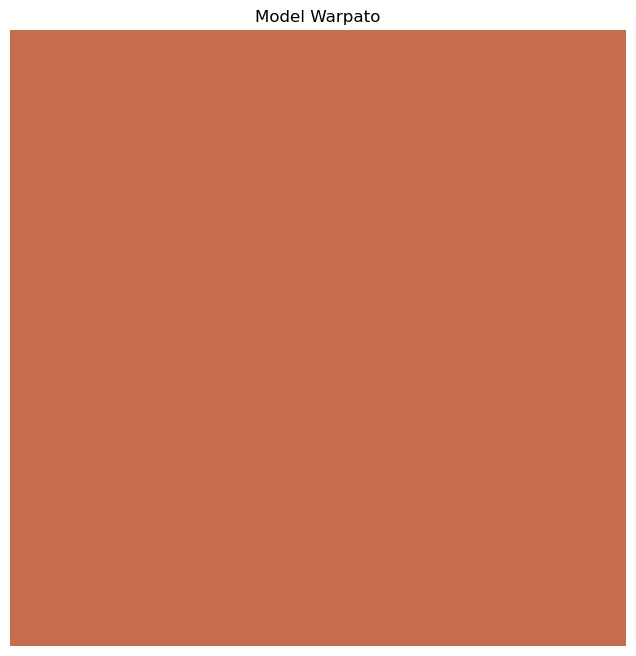

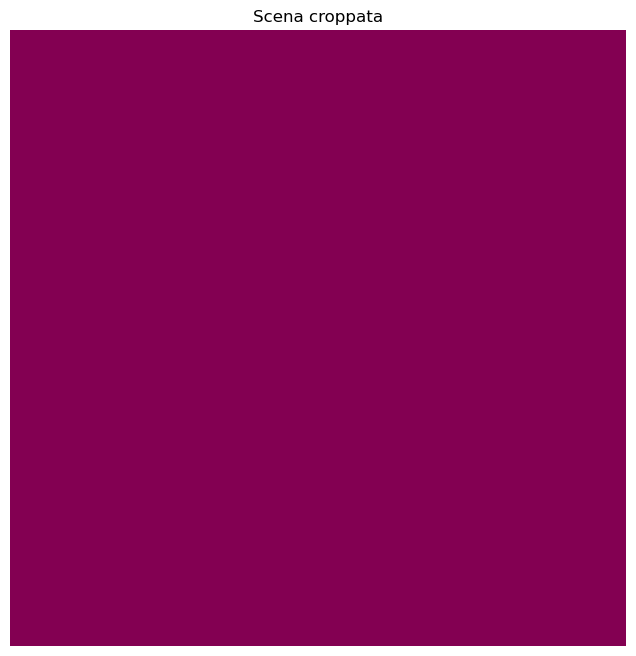

In [54]:
model_idx = 11   # 3, 8, 3, 0, 11, 8
scene_idx = 2    # 6, 5, 2, 3, 5, 1
 
model = models_multiple_instances[model_idx]
scene = scenes_multiple_instances[scene_idx]

multi_object_retrieve(model, scene, [])
